## Tacotron 2 + WaveGlow inference code

## DevOps

Use Pytorch 1.0 with NGC 18.09+. You could duplicate with custom build docker base on NGC 18.11. 

```
docker pull hryu/pytorch:t2-ngc-18.11 
docker run –runtime=nvidia  -ti –v/shared:/shared –v/mnt:/mnt –p8888:8888  hryu/pytorch:t2-ngc-18.11 bash
nvidia-smi 
cd /mnt && jupyter notebook --ip=0.0.0.0 --port=8888 --no-browser --allow-root  --NotebookApp.token='' --notebookDir=/mnt

```

In [1]:
!nvidia-smi

Wed Nov 28 08:55:32 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.48                 Driver Version: 410.48                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00002726:00:00.0 Off |                    0 |
| N/A   30C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

###  clone waveglow and tacotron model

In [2]:
%%bash
rm -rf waveglow
git clone https://github.com/NVIDIA/waveglow.git
cd waveglow
git submodule init
git submodule update --remote --merge

Submodule 'tacotron2' (http://github.com/NVIDIA/tacotron2) registered for path 'tacotron2'
Submodule path 'tacotron2': checked out '6e430556bd4e1404c4dbf7cf4c790b4dd53ee93d'


Cloning into 'waveglow'...
Cloning into 'tacotron2'...


### Download checkpoint file 

In [3]:
import requests

def download_file_from_google_drive(id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)




In [4]:
%%time
destination="tacotron2_statedict.pt"
file_id="1c5ZTuT7J08wLUoVZ2KkUs_VdZuJ86ZqA"
download_file_from_google_drive(file_id, destination)

CPU times: user 196 ms, sys: 202 ms, total: 398 ms
Wall time: 1.78 s


In [5]:
%%time
destination="waveglow_old.pt"
file_id="1cjKPHbtAMh_4HTHmuIGNkbOkPBD9qwhj"
download_file_from_google_drive(file_id, destination)

CPU times: user 3.3 s, sys: 4.7 s, total: 8 s
Wall time: 20.9 s


### Import libraries and setup matplotlib

In [6]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib
matplotlib.use("Agg")
import matplotlib.pylab as plt
import IPython.display as ipd

import numpy as np
import torch

%matplotlib inline

In [7]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

In [8]:
import os
import sys
import time
import numpy as np
from scipy.io.wavfile import write
import torch
sys.path.insert(0, 'waveglow')
sys.path.insert(0, 'waveglow/tacotron2')

In [9]:
from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence

### Setup hparams

In [10]:
hparams = create_hparams()
hparams.sampling_rate = 22050

### Load Tacotron2 model from checkpoint

In [11]:
%%time
checkpoint_path = "tacotron2_statedict.pt"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.eval()

CPU times: user 1.61 s, sys: 704 ms, total: 2.31 s
Wall time: 2.31 s


### Load WaveGlow for mel2audio synthesis

In [12]:
%%time
waveglow_path ="waveglow_old.pt"
waveglow = torch.load(waveglow_path)['model']

CPU times: user 709 ms, sys: 738 ms, total: 1.45 s
Wall time: 1.45 s


### Prepare text input

In [13]:
text = "There's a way to measure the acute emotional intelligence that has never gone out of style."

In [14]:
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

### Decode text input and plot results

In [15]:
%%time
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)

CPU times: user 762 ms, sys: 65.5 ms, total: 828 ms
Wall time: 827 ms


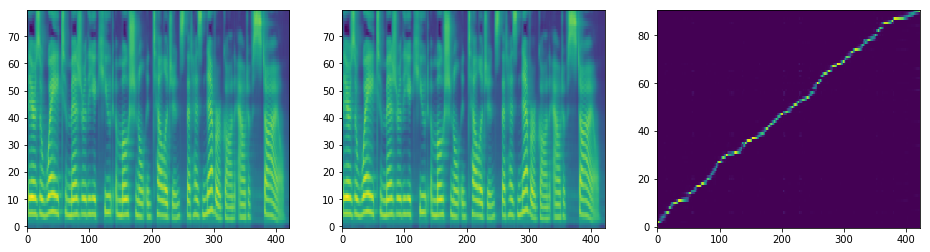

In [16]:
plot_data((mel_outputs.data.cpu().numpy()[0],
           mel_outputs_postnet.data.cpu().numpy()[0],
           alignments.data.cpu().numpy()[0].T))

### Synthesize audio from spectrogram using WaveGlow¶

In [17]:
%%time
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)

CPU times: user 8.37 s, sys: 6.44 s, total: 14.8 s
Wall time: 14.8 s


In [18]:
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

### Appendix
Test more sentences.
Select one sentence from below test sentences.
```
"Scientists at the CERN laboratory say they have discovered a new particle." 
"There's a way to measure the acute emotional intelligence that has never gone out of style." 
"President Trump met with other leaders at the Group of 20 conference." 
"The Senate's bill to repeal and replace the Affordable Care Act is now imperiled." 
"Generative adversarial network or variational auto-encoder.",
"The buses aren't the problem, they actually provide a solution." 
"peter piper picked a peck of pickled peppers how many peppers did peter piper pick." 
"Some have accepted this as a miracle without any physical explanation."
"Generative adversarial network or variational auto-encoder."
"Basilar membrane and otolaryngology are not auto-correlations."
"He has read the whole thing."
"He reads books."
"Thisss isrealy awhsome."
"This is your personal assistant, Google Home."
"The buses aren't the problem, they actually provide a solution."
"The quick brown fox jumps over the lazy dog."
"Talib Kweli confirmed to AllHipHop that he will be releasing an album in the next year."
"The blue lagoon is a nineteen eighty American romance adventure film."
"Tajima Airport serves Toyooka."
"The forecast for San Mateo tomorrow is sixty one degrees and mostly sunny."
"The Blue Lagoon is a 1980 American romance and adventure film directed by Randal Kleiser."
"That girl did a video about Star Wars lipstick."
"She earned a doctorate in sociology at Columbia University"
"George Washington was the first President of the United States."
"I'm too busy for romance." ```

In [19]:
text = "Scientists at the CERN laboratory say they have discovered a new particle."

In [21]:
%%time
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)

CPU times: user 3.21 s, sys: 2.27 s, total: 5.48 s
Wall time: 5.48 s


In [22]:
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)